# Epymorph dev log: June 30th, 2023

_author: Tyler Coles_

_as of git hash: 034c9b3c7c3c74db9892f49199b3f3511f137e1b_

Introducing epymorph's CompartmentModel system for specifying IPMs. In its current form, this is a declarative system using Python object syntax. This represents a step improvement over our current system of defining IPMs as procedural implementations of a base class, which leaves to the developer most of the responsibility for encoding the model computation. It does not represent our ultimate goal. However it is a step on that path.

Let's start by seeing it in action with a couple examples.

## The Pei Model

To recap: the Pei SIRS flu model uses a beta value that varies over time in response to local humidity.

For reference, here's the transition diagram:

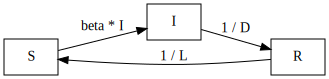

In [3]:
import pydot
from IPython.core.display import SVG

diagram_dot = """digraph {
    rankdir=LR;
    node [shape=box];
    S -> I [label="beta * I"];
    I -> R [label="1 / D"];
    R -> S [label="1 / L"]
}"""
diagram = pydot.graph_from_dot_data(diagram_dot)[0]  # type: ignore
SVG(data=diagram.create_svg())


Where $L$ is the average period of immunity and $D$ is the mean infectious period.

And in the beta equation:

$$
\beta_t = \frac{R_{0 min} + e^{a H_t + log(R_{0 max} - R_{0 min})}}{D}
$$

$H_t$ represents humidity over time, and $a$, $R_{0 min}$, and $R_{0 max}$ are constants whose values have been derived from other research.

### Specifying the IPM

Now we get into epymorph specifics. There are two steps in using the CompartmentModel system.

1. Declare and extract symbols representing the model compartments and required geo/parameter attributes.
2. Use the symbols to define the model transitions and the rate equations for each transition.

In [4]:
from sympy import exp

from epymorph.ipm.attribute import geo, param
from epymorph.ipm.compartment_ipm import (CompartmentModel,
                                          CompartmentModelIpmBuilder)
from epymorph.ipm.compartment_model import (create_model, create_symbols, edge,
                                            quick_compartments)

# We have compartments S, I, and R;
# and attributes D, L,(from the simulation parameters) and H (from the geo).
symbols = create_symbols(
    compartments=quick_compartments('S I R'),
    attributes=[
        # Attribute constructor functions take arguments for:
        # 1. the symbol name,
        # 2. its name in the parameters dictionary (if different from #1),
        # 3. a shape description (which defaults to scalar)
        # 4. a data type (which defaults to Python float)
        param('D', 'infection_duration'),
        param('L', 'immunity_duration'),
        geo('H', 'humidity', shape='TxN'),
    ])

# Extract the symbols so we can use sympy math operators to build equations.
[S, I, R] = symbols.compartment_symbols
[D, L, H] = symbols.attribute_symbols

# For the sake of readability and re-use, we can define expressions as needed.
# Here's our beta function, filling in known constants.
# (Although we certainly could have decided to make these constants parameters as well.)
beta = (0.7 * exp(-180 * H) + 1.3) / D

# And now we can define our model by:
# 1. providing the symbols we just declared, and
# 2. specifying the transition edges and their associated rate equations.
pei: CompartmentModel = create_model(
    symbols=symbols,
    transitions=[
        # The edge constructor takes arguments for:
        # 1. the source compartment,
        # 2. the destination compartment,
        # 3. the rate equation as a sympy Expression
        edge(S, I, rate=beta * S * I / (S + I + R)),
        edge(I, R, rate=I / D),
        edge(R, S, rate=R / L)
    ])


Note that this code is fully declarative; there are no necessarily-procedural elements. This makes it imminently suitable to translation between other formats, such as text files or as the data model of a graphical builder GUI.

### Running the simulation

Now that we have a CompartmentModel defined, we can wrap that with a CompartmentModelIpmBuilder and pass it to the Simulation constructor. This part is basically the same as running a simulation with any of the previously developed IPMs.


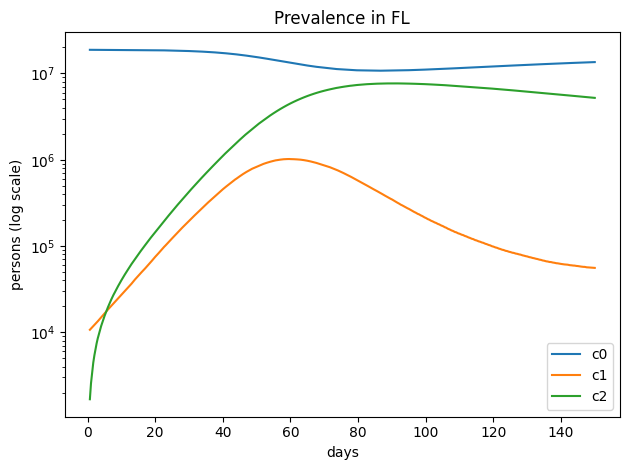

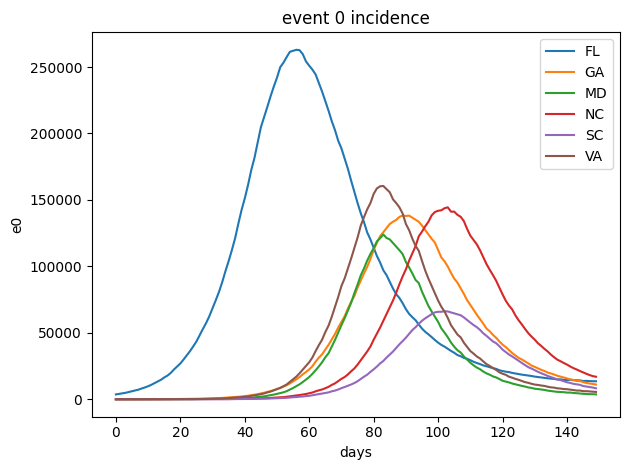

In [5]:
from datetime import date

from epymorph.data import geo_library, mm_library
from epymorph.run import plot_event, plot_pop
from epymorph.simulation import Simulation

sim = Simulation(
    geo=geo_library['pei'](),
    ipm_builder=CompartmentModelIpmBuilder(pei),
    mvm_builder=mm_library['pei']())

out = sim.run(
    param={
        # movement model parameters
        'theta': 0.1,
        'move_control': 0.9,

        # IPM parameters
        'infection_duration': 4.0,
        'immunity_duration': 90.0,

        # compartment initialization (a subject for future improvements)
        'infection_seed_loc': 0,
        'infection_seed_size': 10_000
    },
    start_date=date(2015, 1, 1),
    duration_days=150
)

plot_pop(out, 0)
plot_event(out, 0)


Note: these plots aren't currently smart-enough to know what to call the compartments or events, so they just use `c0`, `e0`, etc. But one advantage of having the CompartmentModel object is that it does have name info and could be used to improve plotting, etc.

`c0`, `c1`, and `c2` are S, I, and R respectively.

`e0` is the infection event (S-to-I).

## The SPARSEMOD COVID-19 model

Now we look at constructing [a more involved model, this one for COVID-19](https://www.medrxiv.org/content/10.1101/2021.05.13.21256216v1). The most significant difference (besides that there are more states and more parameters) is that this model contains forked transitions -- that is, a set of edges which go from a common starting compartment to more than one destination compartment, sharing a base occurrence rate which is split between destinations by a simple ratio.

For example: in this model an Exposed individual ($E$) can progress either to the Infected Asymptomatic ($I_a$) or Infected Pre-symptomatic ($I_p$) compartment. The base rate (expressing individuals which transition to either of those compartments combined) is $E \delta_1$. Then $\rho_1$ of those individuals progress to $I_a$, and $1 - \rho_1$ progress to $I_p$, where $0 \le \rho_1 \le 1$.

We can also write that as two edge rates where the base rate and the proportion are pre-multiplied:

$$
E \delta_1 \rho_1
$$

$$
E \delta_1 (1 - \rho_1)
$$

CompartmentModel will use this form to _define_ forked transitions, however the epymorph engine does not treat them as wholly independent calcuations. In brief: a simple edge is resolved by a poisson draw; a fork is a poisson draw (using the base rate) followed by a multinomial draw (using the proportions).

Let's define our symbols, using a more verbose syntax than we saw earlier. This will allow us to provide more descriptive names for the compartments.

In [6]:
from epymorph.ipm.compartment_model import compartment, create_symbols
from epymorph.ipm.compartment_model import create_model, edge, fork

symbols = create_symbols(
    # So I have a symbol name and a descriptive name for each.
    # (The descriptive names aren't currently being used, but could be useful for debugging, plotting, etc.)
    compartments=[
        compartment('S',   'susceptible'),
        compartment('E',   'exposed'),
        compartment('Ia',  'infected asymptomatic'),
        compartment('Ip',  'infected presymptomatic'),
        compartment('Is',  'infected symptomatic'),
        compartment('Ib',  'infected bed-rest'),
        compartment('Ih',  'infected hospitalized'),
        compartment('Ic1', 'infected in ICU'),
        compartment('Ic2', 'infected in ICU Step-Down'),
        compartment('D',   'deceased'),
        compartment('R',   'recovered')
    ],
    # For these attributes, the symbol name and the params file name are the same,
    # so I don't have to repeat myself.
    # But this time I'm going to choose to be explicit about the fact that I expect these to be scalar floats.
    attributes=[
        param('beta_1',  shape='S', dtype='float'),
        param('omega_1', shape='S', dtype='float'),
        param('omega_2', shape='S', dtype='float'),
        param('delta_1', shape='S', dtype='float'),
        param('delta_2', shape='S', dtype='float'),
        param('delta_3', shape='S', dtype='float'),
        param('delta_4', shape='S', dtype='float'),
        param('delta_5', shape='S', dtype='float'),
        param('gamma_a', shape='S', dtype='float'),
        param('gamma_b', shape='S', dtype='float'),
        param('gamma_c', shape='S', dtype='float'),
        param('rho_1',   shape='S', dtype='float'),
        param('rho_2',   shape='S', dtype='float'),
        param('rho_3',   shape='S', dtype='float'),
        param('rho_4',   shape='S', dtype='float'),
        param('rho_5',   shape='S', dtype='float')
    ])

# Again extract the symbols, there's just a lot more this time.
[S, E, Ia, Ip, Is, Ib, Ih, Ic1, Ic2, D, R] = symbols.compartment_symbols
[beta_1, omega_1, omega_2, delta_1, delta_2, delta_3, delta_4, delta_5,
    gamma_a, gamma_b, gamma_c, rho_1, rho_2, rho_3, rho_4, rho_5] = symbols.attribute_symbols

# It's handy to specify some intermediate expressions for the total number of people and our \lambda_1
N = S + E + Ia + Ip + Is + Ib + Ih + Ic1 + Ic2 + D + R

lambda_1 = (omega_1 * Ia + Ip + Is + Ib + omega_2 * (Ih + Ic1 + Ic2)) / (N - D)

# Now define the transitions.
sparsemod = create_model(
    symbols=symbols,
    transitions=[
        edge(S, E, rate=beta_1 * lambda_1 * S),

        # This is the fork we talked about earlier! E -> {Ia,Ip}
        # Wrapping `edge`s with a `fork` alerts epymorph that these
        # should not be treated as statistically independent events,
        # but that they share a common base rate and a proportional split.
        fork(
            edge(E, Ia, rate=E * delta_1 * rho_1),
            edge(E, Ip, rate=E * delta_1 * (1 - rho_1))
        ),

        edge(Ip, Is, rate=Ip * delta_2),

        # And here's a fork with three destinations and two proportional parameters.
        fork(
            edge(Is, Ib,  rate=Is * delta_3 * (1 - rho_2 - rho_3)),
            edge(Is, Ih,  rate=Is * delta_3 * rho_2),
            edge(Is, Ic1, rate=Is * delta_3 * rho_3)
        ),

        fork(
            edge(Ih, Ic1, rate=Ih * delta_4 * rho_4),
            edge(Ih, R,   rate=Ih * delta_4 * (1 - rho_4))
        ),
        fork(
            edge(Ic1, D,   rate=Ic1 * delta_5 * rho_5),
            edge(Ic1, Ic2, rate=Ic1 * delta_5 * (1 - rho_5))
        ),
        edge(Ia, R,  rate=Ia * gamma_a),
        edge(Ib, R,  rate=Ib * gamma_b),
        edge(Ic2, R, rate=Ic2 * gamma_c)
    ])


Speaking generally, the method here is the same as for the Pei model, just more. The same could be said for running the simulation.

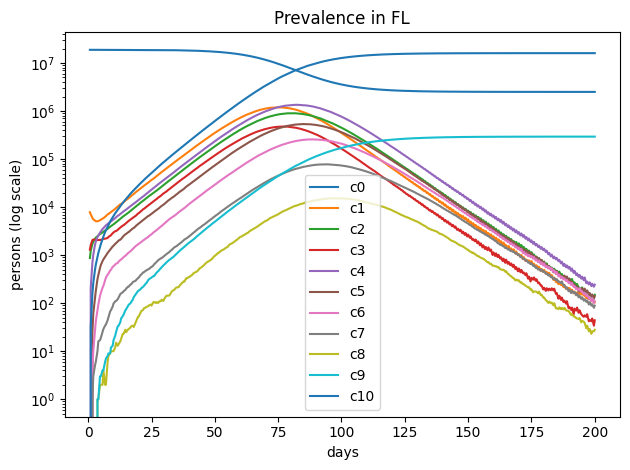

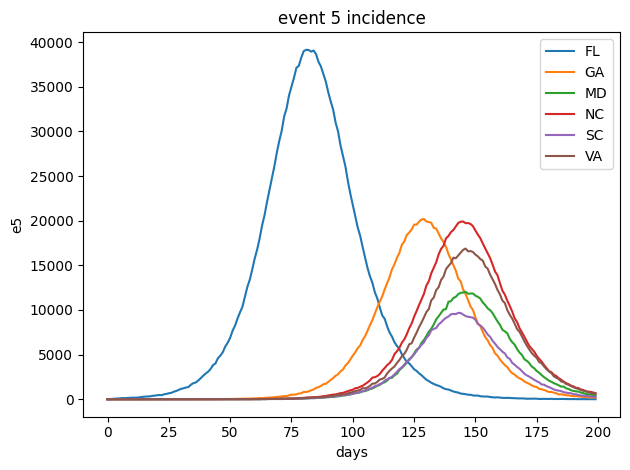

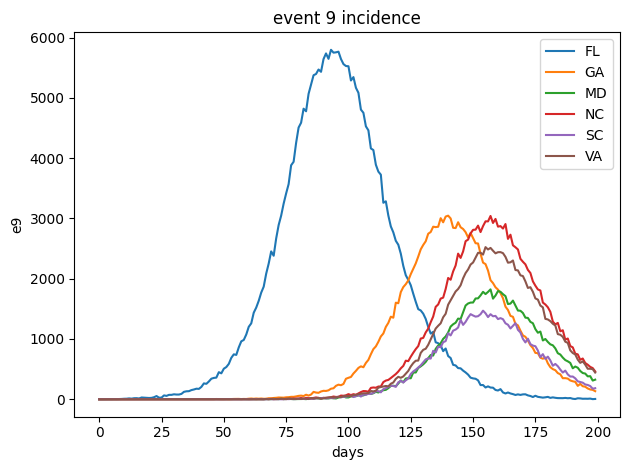

In [7]:
from datetime import date

from epymorph.data import geo_library, mm_library
from epymorph.run import plot_event, plot_pop
from epymorph.simulation import Simulation

sim = Simulation(
    geo=geo_library['pei'](),
    ipm_builder=CompartmentModelIpmBuilder(sparsemod),
    mvm_builder=mm_library['pei']())

out = sim.run(
    param={
        # movement model params
        'move_control': 1,
        'theta': 0.1,

        # IPM params
        'beta_1': 0.3,
        'omega_1': 0.55,
        'omega_2': 0.05,
        'delta_1': 0.333,
        'delta_2': 0.5,
        'delta_3': 0.166,
        'delta_4': 0.142,
        'delta_5': 0.125,
        'gamma_a': 0.166,
        'gamma_b': 0.333,
        'gamma_c': 0.25,
        'rho_1': 0.4,
        'rho_2': 0.175,
        'rho_3': 0.015,
        'rho_4': 0.2,
        'rho_5': 0.6,

        # compartment initialization
        'infection_seed_loc': 0,
        'infection_seed_size': 10000,
    },
    start_date=date(2015, 1, 1),
    duration_days=200,
)

plot_pop(out, 0)  # Florida prevalence

plot_event(out, 5)  # 5: Is->Ih: hospitalizations, non-ICU
plot_event(out, 9)  # 9: Ic1->D: deaths


We chose to graph all compartments for the first node, as well as choosing two events of interest to plot for all nodes -- non-ICU hospitalizations (event 5) and deaths (event 9). You may notice that the numbering of the events follows the order in which the edge was specified in the model (starting from zero, and for the sake of ordering we can ignore the detail that some edges are in forks).